In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [3]:
# SVHN mean and std calculated over the dataset
SVHN_MEAN = [0.4377, 0.4438, 0.4728]
SVHN_STD = [0.1980, 0.2010, 0.1970]
IMAGE_SIZE = 32 # SVHN images are 32x32

# Transforms with Data Augmentation for Training
transform_train = transforms.Compose([
    transforms.RandomRotation(5), # Randomly rotate by +/- 5 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), # Randomly change color properties
    transforms.ToTensor(),
    transforms.Normalize(mean=SVHN_MEAN, std=SVHN_STD),
])

# Transforms for Testing (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=SVHN_MEAN, std=SVHN_STD),
])

batch_size = 128 # Increased batch size is common for smaller images

# Load the SVHN dataset
# split='train' is the standard training set
train_set = datasets.SVHN(root='./data', split='train', download=True, transform=transform_train)
# split='test' is the standard test set
test_set = datasets.SVHN(root='./data', split='test', download=True, transform=transform_test)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

# SVHN classes are digits 0-9. (Note: The SVHN dataset labels 1-9 then 0 as 10, but PyTorch maps this to 0-9)
classes = [str(i) for i in range(10)]
print(f'SVHN dataset loaded. Training samples: {len(train_set)}, Test samples: {len(test_set)}')

100%|██████████| 182M/182M [08:18<00:00, 365kB/s]    
100%|██████████| 64.3M/64.3M [00:18<00:00, 3.46MB/s]


SVHN dataset loaded. Training samples: 73257, Test samples: 26032


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Input: 3x32x32 (RGB image)
        self.features = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # Output: 32x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # Output: 32x16x16
            
            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: 64x16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # Output: 64x8x8
            
            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Output: 128x8x8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # Output: 128x4x4
        )
        
        # Classifier (Flatten and Fully Connected Layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5), # Regularization
            nn.Linear(128 * 4 * 4, 512), # 128 * 4 * 4 = 2048
            nn.ReLU(),
            nn.Linear(512, len(classes)) # Output layer for 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model
model = SimpleCNN()

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of trainable parameters: {num_params:,}')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

Total number of trainable parameters: 1,147,466


In [5]:
num_epochs = 15 # Increased epochs to reach reasonable accuracy on SVHN

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

    for i, (inputs, labels) in enumerate(progress_bar):
        inputs, labels = inputs.to(device), labels.to(device)

        optimiser.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        
        # Update progress bar with current loss
        current_loss = running_loss / (i + 1) 
        progress_bar.set_postfix({'loss': current_loss})

print('Finished Training')

Epoch 15/15: 100%|██████████| 573/573 [00:21<00:00, 26.90batch/s, loss=0.219]

Finished Training


In [6]:
model.eval()
correct = 0
total = 0
all_labels = []
all_predicted = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

final_accuracy = 100 * correct / total
print(f'Accuracy of the network on the SVHN test set: {final_accuracy:.2f}%')

Accuracy of the network on the SVHN test set: 93.50%


### ✅ Correct Predictions Examples:


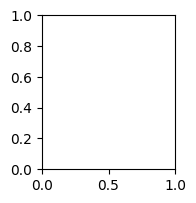

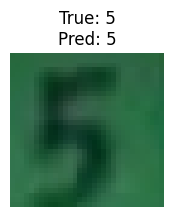

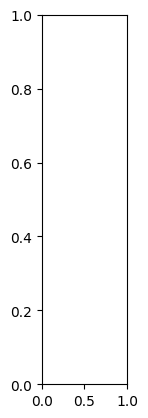

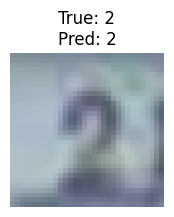

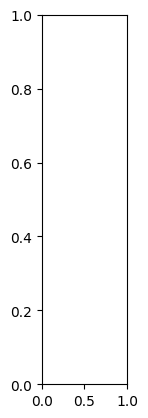

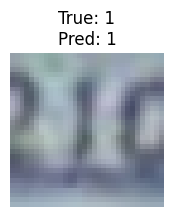

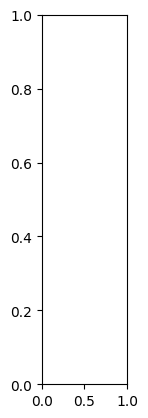

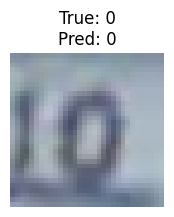

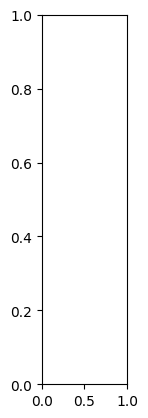

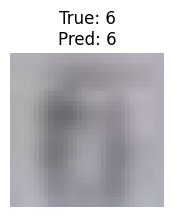


### ❌ Incorrect Predictions (Hard Examples):


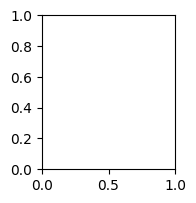

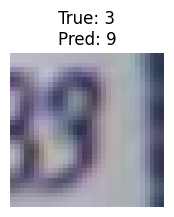

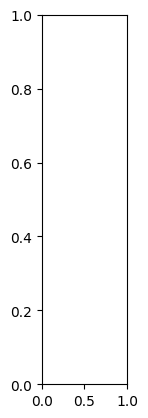

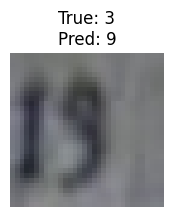

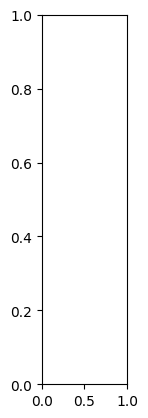

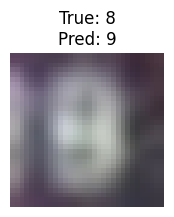

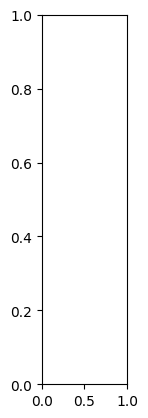

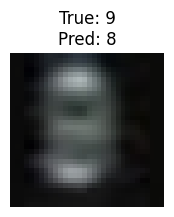

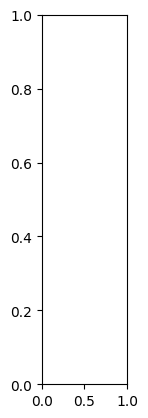

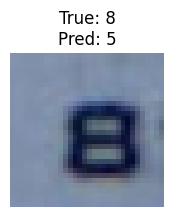

In [ ]:
def imshow(img, title=None):
    # Un-normalize the image (reverse the normalization transformation)
    # SVHN_STD is used for std, SVHN_MEAN for mean
    img = img * torch.tensor(SVHN_STD).view(3, 1, 1) + torch.tensor(SVHN_MEAN).view(3, 1, 1)
    np_img = img.numpy()
    plt.figure(figsize=(2, 2))
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get a batch of test data
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Make predictions on the batch
model.eval()
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)

# Move tensors back to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Find indices for correct and incorrect predictions
correct_indices = (predicted == labels).nonzero(as_tuple=True)[0]
wrong_indices = (predicted != labels).nonzero(as_tuple=True)[0]

# --- Display Correct Predictions ---
print("### ✅ Correct Predictions Examples:")
plt.figure(figsize=(10, 2))
for i in range(min(5, len(correct_indices))):
    idx = correct_indices[i].item()
    imshow(images[idx], title=f'True: {classes[labels[idx]]}\nPred: {classes[predicted[idx]]}')
plt.show()

# --- Display Incorrect Predictions (Hard Examples) ---
print("\n### ❌ Incorrect Predictions (Hard Examples):")
plt.figure(figsize=(10, 2))
for i in range(min(5, len(wrong_indices))):
    idx = wrong_indices[i].item()
    imshow(images[idx], title=f'True: {classes[labels[idx]]}\nPred: {classes[predicted[idx]]}')
plt.show()

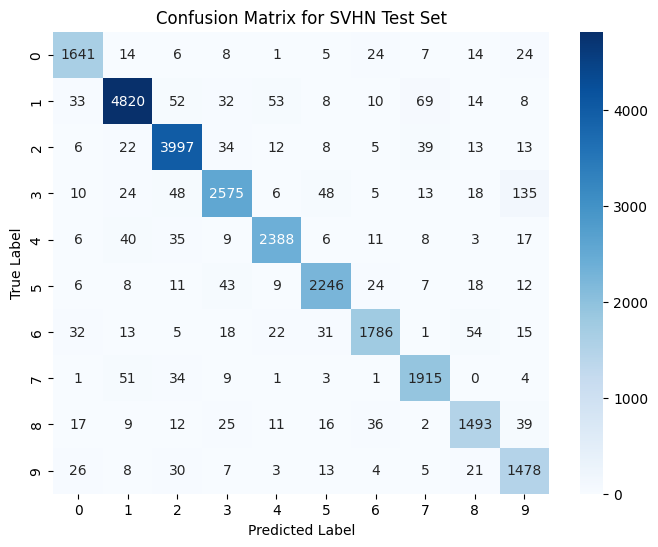

In [8]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predicted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix for SVHN Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()